# Exploring groundwater data from Lizard

In this notebook, you will experiment how to use the `hydropandas` package to access, visualize and explore meta data from Lizard, a cloud datawarehouse that can be used to store groundwater observations. Data sources:
1. Vitens (default, public access): Vitens is the largest drinking water company in the Netherlands, and it has more than 10.000 groundwater wells and more than 50.000 timeseries in its datawarehouse. The data spans from the 1930’s to the present, and it is constantly updated with new observations. Vitens also validates the data using ArtDiver and provides quality flags and comments for each observation. The data is open to the public and you can find more information at https://vitens.lizard.net.
2. Others: If you have access to other Lizard data sources, you can specify the `source` parameter in the `lizard` functions to access those data sources. Currently, only "vitens" is officially supported. Note that you then may need to specify authentication as well by means of a personal API key.

---

Feel free to customize and expand upon this introduction as needed. Happy coding! 🚀🌍📊


## <a id=top></a>Notebook contents

1. [Find groundwater wells on a map](#extent)
2. [Analyse groundwater observations](#gwobs)
3. [Build a Pastas model](#pastas)

In [1]:
import pastas as ps

import hydropandas as hpd

In [2]:
hpd.util.get_color_logger("INFO")

<RootLogger root (INFO)>

The `vitens` data source is used by default, and does not require authentication. If you have access to other Lizard data sources, you can specify the `source` parameter in the `read_lizard` function to access those data sources. Currently, only "vitens" is officially supported.

For others than Vitens, you may need authentication. You can use the `auth` parameter to pass your credentials. According to the [Lizard documentation](https://docs.lizard.net/c_endpoints.html#authentication), you should create a personal API key at `https://{organisation}.lizard.net/management/` and enter that in the cell below. If you do not have access to other data sources, you can use `auth=None` to skip authentication.

In [ ]:
# Settings for 'vitens' (default) data source
source = "vitens" 
auth = None

## UNCOMMENT AND SET YOUR API KEY IF YOU NEED TO SPECIFY CREDENTIALS
#your_api_key = "your_api_key_here" 
#auth = ("__key__", your_api_key)

## Get observations from extent <a id=extent></a>

Use `ObsCollection` to find monitoring wells by specifying a geographical extent in Rijksdriehoeks coordinates.

In [17]:
my_extent = (137000, 138000, 458000, 459000)
oc = hpd.read_lizard(extent=my_extent, source=source, auth=auth)

INFO:hydropandas.io.lizard.get_obs_list_from_extent:Number of monitoring wells: 1
INFO:hydropandas.io.lizard.get_obs_list_from_extent:Number of pages: 1


monitoring well: 100%|██████████| 1/1 [00:04<00:00,  4.38s/it]


Visualize all groundwater wells inside the extent on a map (visualize the `ObsCollection`). The markers are clickable to show a preview of the availables observations.

In [4]:
oc.plots.interactive_map(color="red", zoom_start=15, tiles="Esri.WorldImagery")

Print all the retrieved groundwater wells and tubes, and make a plot of the observations.

In [12]:
oc

,x,y,location,filename,source,unit,tube_nr,screen_top,screen_bottom,ground_level,tube_top,metadata_available,obs
name,,,,,,,,,,,,,
UPWP016001,137401.64297,458893.683528,B31H0580,,lizard,m NAP,1,-22.43,-24.43,1.58,2.198,True,GroundwaterObs UPWP016001 -----metadata------ ...
UPWP016003,137401.64297,458893.683528,B31H0580,,lizard,m NAP,3,-65.43,-67.43,1.58,2.141,True,GroundwaterObs UPWP016003 -----metadata------ ...
UPWP016002,137401.64297,458893.683528,B31H0580,,lizard,m NAP,2,-53.93,-55.93,1.58,2.178,True,GroundwaterObs UPWP016002 -----metadata------ ...


INFO:hydropandas.extensions.plots.section_plot:created sectionplot -> UPWP016001
INFO:hydropandas.extensions.plots.section_plot:created sectionplot -> UPWP016003
INFO:hydropandas.extensions.plots.section_plot:created sectionplot -> UPWP016002


(<Figure size 1500x500 with 2 Axes>,
 [<Axes: ylabel='m NAP'>, <Axes: ylabel='m NAP'>])

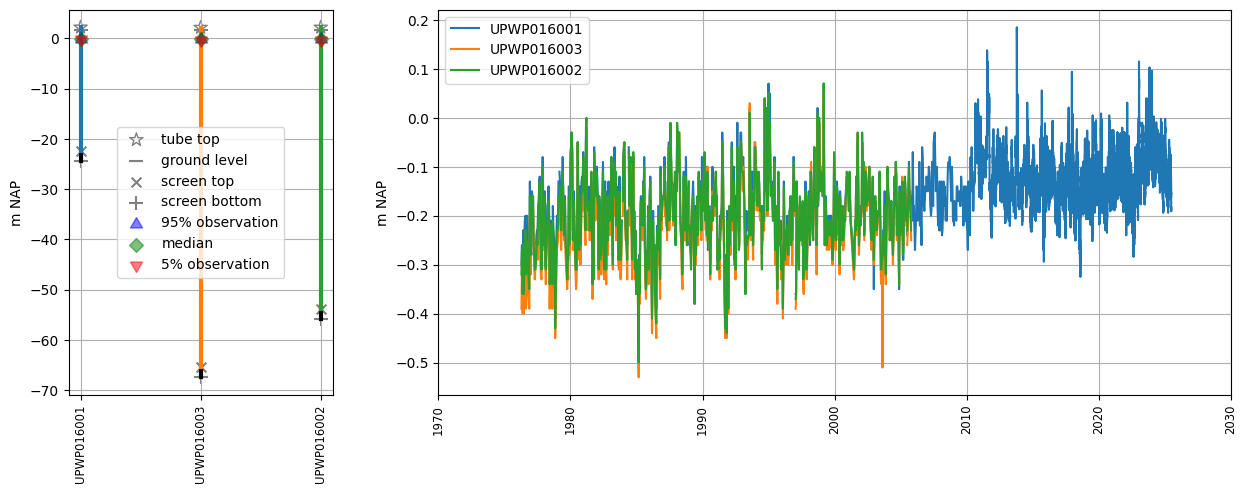

In [6]:
oc.plots.section_plot(plot_obs=True)

## Groundwater observations <a id=gwobs></a>

Now lets download the groundwater level observation using the `from_lizard` function of a `GroundwaterObs` object. The code below reads the groundwater level timeseries for the well UPWP016 from Lizard and makes a plot.

In [15]:
gw_lizard = hpd.GroundwaterObs.from_lizard(
    "UPWP016", tmin="1900-01-01", tmax="2030-01-01", source=source, auth=auth,
)
print(gw_lizard)

ax = gw_lizard["value"].plot(
    figsize=(12, 5),
    marker=".",
    grid=True,
    label=gw_lizard.name,
    legend=True,
    xlabel="Date",
    ylabel="m NAP",
    title="Groundwater observations for " + gw_lizard.name,
)

NameError: name 'source' is not defined

The groundwater observations contain a validation flag per timestamp. These can 'betrouwbaar' (reliable), 'onbetrouwbaar' (unreliable) en 'onbeslist' (unvalidated). Below flags of the timeseries are shown as a percentage, and the unreliable timestamps are printed.

In [8]:
print(gw_lizard["flag"].value_counts(normalize=True) * 100)
gw_lizard[gw_lizard["flag"] == "onbetrouwbaar"]

flag
betrouwbaar      99.982118
onbetrouwbaar     0.014902
onbeslist         0.002980
Name: proportion, dtype: float64


,UPWP016001
x,137401.64297
y,458893.683528
location,B31H0580
filename,
source,lizard
unit,m NAP
tube_nr,1
screen_top,-22.43
screen_bottom,-24.43
ground_level,1.58


## Pastas model <a id=pastas></a>

Lets make a Pastas model for this groundwater well (starting from 2015) and use the nearest KNMI station for meteorological data

INFO:hydropandas.io.knmi.get_knmi_obs:get KNMI data from station nearest to coordinates (137401.64297031244, 458893.6835282785) and meteovariable RH
INFO:hydropandas.io.knmi.fill_missing_measurements:knmi station De Bilt has no measurements for RH after 2025-06-24 01:00:00 and an end date of 2025-06-24 09:00:00 was requested. Changing end to 2025-06-24 01:00:00
INFO:hydropandas.io.knmi._add_missing_indices:station 260 has no measurements after 2025-06-24 01:00:00
INFO:hydropandas.io.knmi.get_knmi_obs:get KNMI data from station nearest to coordinates (137401.64297031244, 458893.6835282785) and meteovariable EV24
INFO:hydropandas.io.knmi.fill_missing_measurements:knmi station De Bilt has no measurements for EV24 after 2025-06-24 01:00:00 and an end date of 2025-06-24 09:00:00 was requested. Changing end to 2025-06-24 01:00:00
INFO:hydropandas.io.knmi._add_missing_indices:station 260 has no measurements after 2025-06-24 01:00:00
INFO:pastas.timeseries._fill_nan:Time Series 'value': 14 nan

[<Axes: xlabel='peil_datum_tijd', ylabel='Head'>,
 <Axes: >,
 <Axes: title={'right': "Stresses: ['RH', 'EV24']"}, ylabel='Rise'>,
 <Axes: title={'center': 'Step response'}>,
 <Axes: title={'left': 'Model parameters ($n_c$=5)'}>]

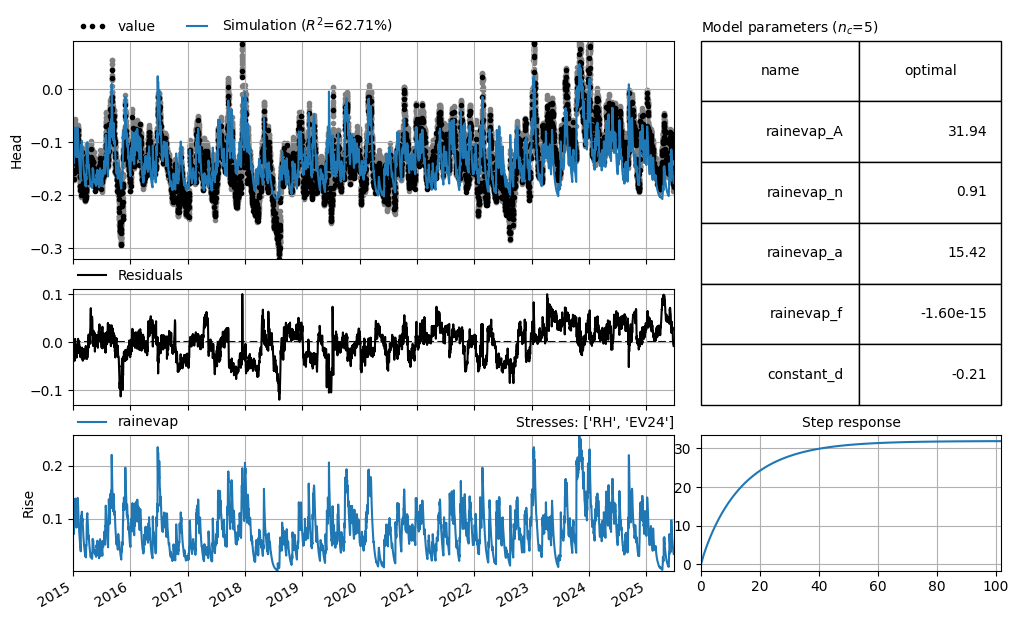

In [9]:
# Get the precipitation and evaporation data from the KNMI
precipitation = hpd.PrecipitationObs.from_knmi(
    xy=(gw_lizard.x, gw_lizard.y),
    start=gw_lizard.index[0],
    end=gw_lizard.index[-1],
    fill_missing_obs=True,
)
evaporation = hpd.EvaporationObs.from_knmi(
    xy=(gw_lizard.x, gw_lizard.y),
    meteo_var="EV24",
    start=gw_lizard.index[0],
    end=gw_lizard.index[-1],
    fill_missing_obs=True,
)

# Create a Pastas Model
ml = ps.Model(gw_lizard["value"], name=gw_lizard.name)

# Add the recharge data as explanatory variable
ts1 = ps.RechargeModel(
    precipitation["RH"].resample("D").first(),
    evaporation["EV24"].resample("D").first(),
    ps.Gamma(),
    name="rainevap",
    settings=("prec", "evap"),
)

# Add the stressmodel to the model and solve for period after 2015
ml.add_stressmodel(ts1)
ml.solve(tmin="2015")
ml.plots.results(figsize=(10, 6))